# <center> Data Science Summer School - Split '16 </center>
(c) 2016 Martin Tutek

version: 0.1

kernel: Python 2.7

# <center>Decision trees</center>
<img style="float: center;" src="img/harolds-planet-dtree.jpg", width="40%" height="40%">

In [1]:
# Python imports & notebook setup
# all plots will appear in the notebook
%matplotlib inline 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # make all the plots prettier
from ipywidgets import interact, interactive, fixed # more plotting magic

from matplotlib import style
style.use('fivethirtyeight') # prettier-plots++

# sklearn models & dataset wrangling
from sklearn import tree 
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons # toy dataset generator

from collections import Counter

# make everything reproducible
np.random.seed(12345)

## Classification
### Reminder: what is a classification problem?

We have $M$ $N$-dimensional input samples and $M$ corresponding class values.

**Input space:** $\mathcal{X} \subset \mathcal{R}^n$
**Output space:** $\mathcal{Y} = \{0, \dots, K\}$

\begin{array}{lllll|l}
&x_1 & x_2 & \cdots & x_n & \mathbf{y}\\
\hline
\mathbf{x}^{(1)} = & x_1^{(1)} & x_2^{(1)} & \cdots & x_n^{(1)} & y^{(1)}\\
\mathbf{x}^{(2)} = & x_1^{(2)} & x_2^{(2)} & \cdots & x_n^{(2)} & y^{(2)}\\
& \vdots\\
\mathbf{x}^{(M)} = & x_1^{(M)} & x_2^{(M)} & \cdots & x_n^{(M)} & y^{(M)}\\
\end{array}

**Our goal:** learn a function $f(X) \to \mathcal{Y} $.

**Dimensions:** input matrix $X_{NxM}$ and output vector $y_M$

## Generate our ~~toy~~ difficult dataset(s)

In [2]:
# generating data
n_samples = 200 # number of points
noise = .05 # gaussian noise
moon_xs, moon_ys = make_moons(n_samples=n_samples, noise=noise) # moon graffiti problem
single_moon = moon_xs[np.where(moon_ys == 0)]  # take just one moon graffiti for later

In [3]:
# Get some basic information about the dataset
print moon_xs.shape
print single_moon.shape

num_classes = moon_xs.shape[1]
print num_classes 

(200, 2)
(100, 2)
2


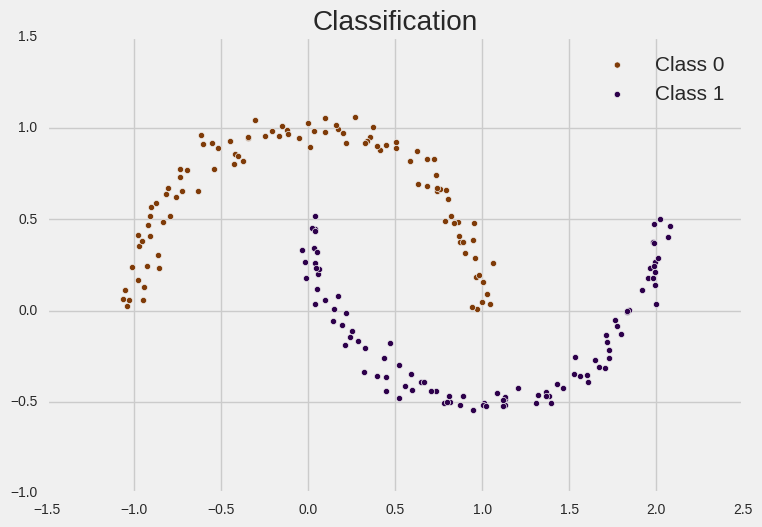

In [4]:
# Plot the low-dimensional data
for yi in range(num_classes):
    plt.scatter(moon_xs[moon_ys == yi, 0], moon_xs[moon_ys == yi, 1], 
                c = plt.cm.PuOr(yi * 256), label = 'Class {}'.format(yi))
plt.title("Classification")
plt.legend(fontsize=15)
plt.show()

In [5]:
def very_complicated_classifier(data):
    predictions = np.zeros(data.shape[0]) # Assuming the first dimension of our data is M
    
    ###############################
    #        YOUR CODE HERE       #
    ###############################
    
    # Create a classifier that makes a decision based on values from a single dimension
    # of the input data. We are working in continuous space, so use > and < to separate
    # based on some value.
    
    # What are the dimensions of our problem? 
    # Where could we split the data for a best classification?
    class_one = np.where(data[:, 1] < 0.)
    predictions[class_one] = 1
    ###############################
    #       END OF YOUR CODE      #
    ###############################
    
    return predictions
        

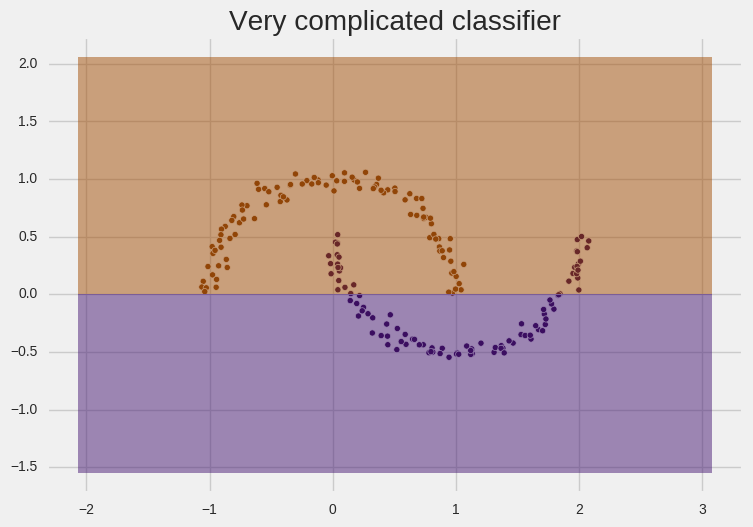

In [6]:
# Generate decision boundary plot data
plot_step = .01 #interval of x and y value steps

x_min, x_max = moon_xs[:, 0].min() - 1, moon_xs[:, 0].max() + 1 # x values range
y_min, y_max = moon_xs[:, 1].min() - 1, moon_xs[:, 1].max() + 1 # y values range

xx, yy = np.meshgrid(
                np.arange(x_min, x_max, plot_step),
                np.arange(y_min, y_max, plot_step)
                    )

vcc_predictions = very_complicated_classifier(np.c_[xx.ravel(), yy.ravel()])
vcc_predictions = vcc_predictions.reshape(xx.shape)

plt.scatter(moon_xs[:, 0], moon_xs[:, 1], c=moon_ys, cmap = plt.cm.PuOr)
cs = plt.contourf(xx, yy, vcc_predictions, cmap = plt.cm.PuOr, alpha=0.5)
plt.title('Very complicated classifier')
plt.show()

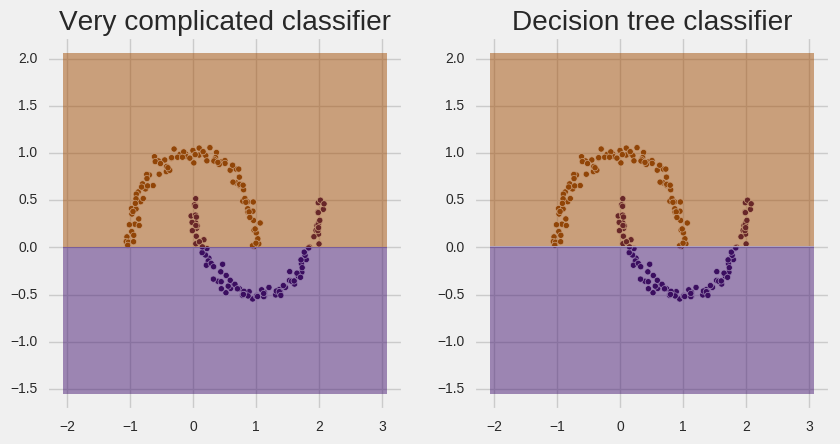

In [7]:
clf = tree.DecisionTreeClassifier(max_depth=1).fit(moon_xs, moon_ys)

dt_prediction = clf.predict(np.c_[xx.ravel(), yy.ravel()])
dt_prediction = dt_prediction.reshape(xx.shape)

# Setup the parallel plots
f, axarr = plt.subplots(1, 2, figsize=(9, 4.5))

# Plot the points
axarr[0].scatter(moon_xs[:, 0], moon_xs[:, 1], c=moon_ys, cmap = plt.cm.PuOr)
# Plot the decision boundary
cs = axarr[0].contourf(xx, yy, vcc_predictions, cmap = plt.cm.PuOr, alpha=0.5)

axarr[0].set_title('Very complicated classifier')


axarr[1].scatter(moon_xs[:, 0], moon_xs[:, 1], c = moon_ys, cmap = plt.cm.PuOr)
cs = axarr[1].contourf(xx, yy, dt_prediction, cmap = plt.cm.PuOr, alpha=0.5)
axarr[1].set_title('Decision tree classifier')
plt.show()

## Introducing the decision tree classifier

> class sklearn.tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, class_weight=None, presort=False)

Great documentation at: **[Click me!](http://scikit-learn.org/stable/modules/tree.html)**

### Which values do we actually pay attention to? (for now)

* **criterion** 
  * The criterion is the method we use to decide on which node to split the tree. In the previous example, we arbitrarily chose a point for splitting, however machines don't have free will. Therefore we define mathematical ways of choosing the best point for splits
  
* **max_depth**  
  * The amount of splits done while growing (training) the tree.


### Visualising the tree

Decision trees are famed due to their **interpretability** and **simplicity**. Even though models based on decision trees which are used in practice are not as interpretable due to using many trees at the same time, it is usually good practice to be able to visualise the result of the $n$ most important ones.

In [8]:
from sklearn.externals.six import StringIO  
import pydotplus

def model_to_plot(classifier, outfile, feature_names=['x', 'y'], class_names=['0', '1']):
    dot_data = StringIO() 
    tree.export_graphviz(classifier, out_file=dot_data,  
                             feature_names=feature_names,  
                             class_names=class_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(outfile) 

outfile = "out/moons.pdf"
model_to_plot(clf, outfile)

from IPython.display import IFrame
IFrame("out/moons.pdf", width=500, height=500)

## The importance of depth

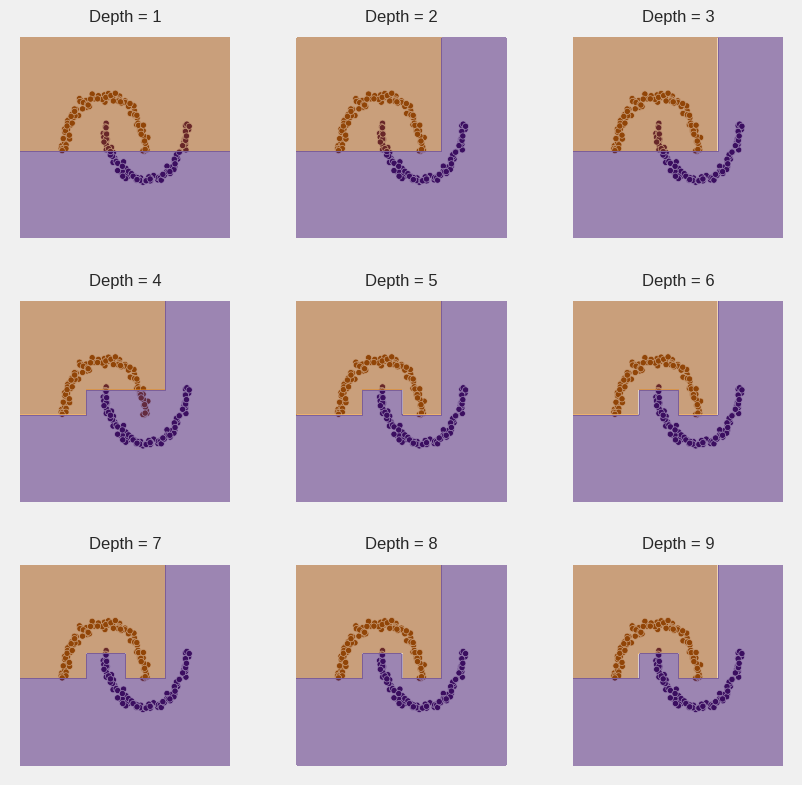

In [9]:
f, axarr = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        depth = i * 3 + j + 1 # complicated magic
        clf = tree.DecisionTreeClassifier(max_depth=depth).fit(moon_xs, moon_ys)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axarr[i,j].scatter(moon_xs[:, 0], moon_xs[:, 1], c = moon_ys, cmap = plt.cm.PuOr)
        cs = axarr[i,j].contourf(xx, yy, Z, cmap = plt.cm.PuOr, alpha=0.5)
        
        axarr[i,j].set_title("Depth = {}".format(depth), fontsize=12)
        axarr[i,j].axes.get_xaxis().set_ticks([])
        axarr[i,j].axes.get_yaxis().set_ticks([])

plt.show() 


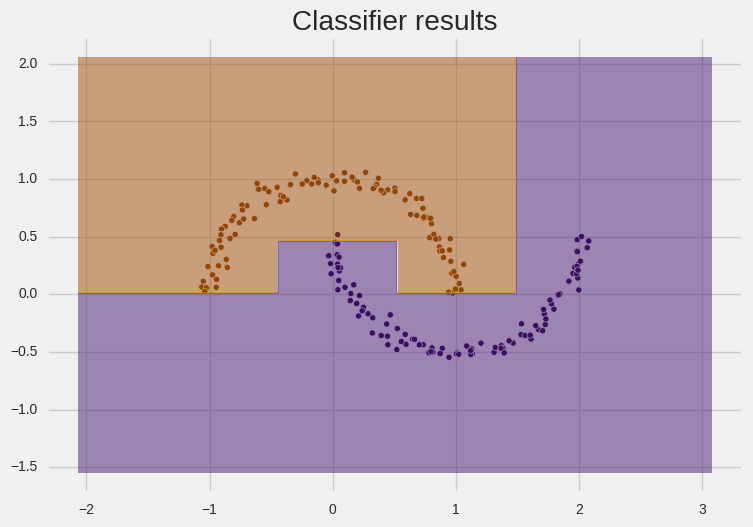

In [10]:
# Interact demo (optional)
@interact(max_depth=(1,10))
def classify(max_depth):
    clf = tree.DecisionTreeClassifier(max_depth=max_depth).fit(moon_xs, moon_ys)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.scatter(moon_xs[:, 0], moon_xs[:, 1], c = moon_ys, cmap = plt.cm.PuOr)
    cs = plt.contourf(xx, yy, Z, cmap = plt.cm.PuOr, alpha=0.5)
    plt.title('Classifier results')
    plt.show()

## Regression

Regression is in its heart the **same** thing as classification, except you can imagine each point as having its own class. The only thing that changes is the definition of the output space - it is no longer a discrete set of possible values, but a (real-valued?) number with possibly infinitely large cardinality.

**Input space:** $\mathcal{X} \subset \mathcal{R}^n$
**Output space:** $\mathcal{Y} \subset \mathcal{R}$

**Our goal:** learn a function $f(X) \to \mathcal{Y} $.

**Dimensions:** input matrix $X_{NxM}$ and output vector $y_M$

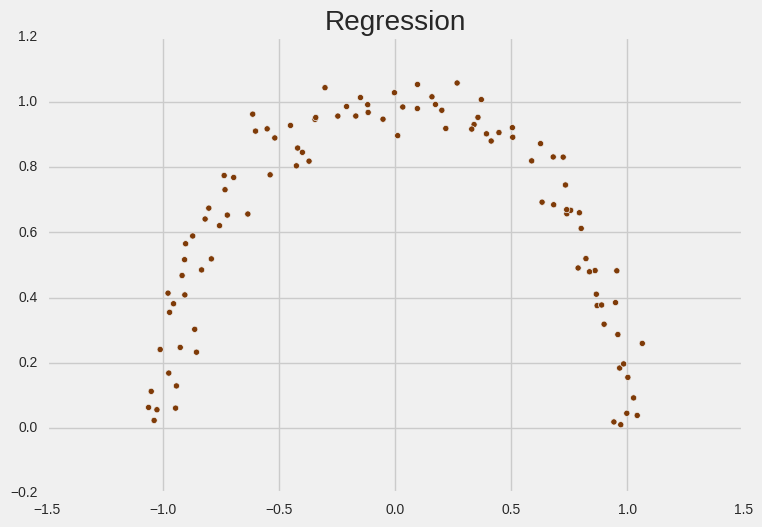

In [11]:
fig = plt.scatter(single_moon[:, 0], single_moon[:, 1], c=np.zeros(single_moon.shape[0]), cmap = plt.cm.PuOr)
plt.title('Regression')
plt.show()

## How to solve this new, completely different problem?
   
Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) instead of [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

Everything else is the same.

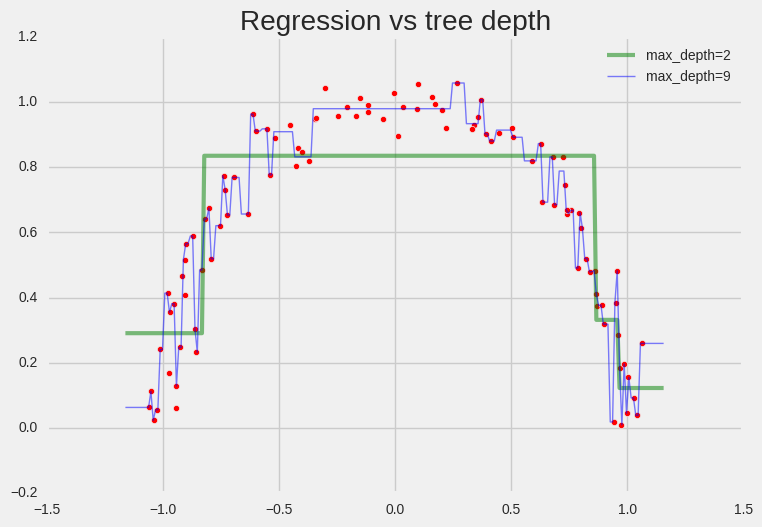

In [12]:
# Now, one of our input dimensions (y) becomes the value which we are trying to predict.
X = single_moon[:, 0]
y = single_moon[:, 1]

# Generate the test data (sample decision points for the whole space of X)
plot_step = .01 
x_min, x_max = X.min() - .1, X.max() + .1
X_test = np.arange(x_min, x_max, plot_step)

# The classifier expects 2d data!
X = X.reshape(X.shape[0], 1)
X_test = X_test.reshape(X_test.shape[0], 1)

# Plot X, y
plt.scatter(X, y, c = 'r')

# Loops are better than copy/pasting
depths = [2, 9] # Regression tree depth
colors = ["g","b"] # Line color
linewidths = [3, 1] # Line width

# Iterate, train, predict and plot
for depth, color, linewidth in zip(depths, colors, linewidths):
    # The magical three lines
    reg = tree.DecisionTreeRegressor(max_depth=depth)
    reg.fit(X,y)
    predictions = reg.predict(X_test)
    
    plt.plot(X_test, predictions, c=color, label="max_depth={}".format(depth), linewidth=linewidth, alpha = 0.5)
    
plt.legend(fontsize='10')
plt.title('Regression vs tree depth')
plt.show()

## The importance of depth 2: Regression

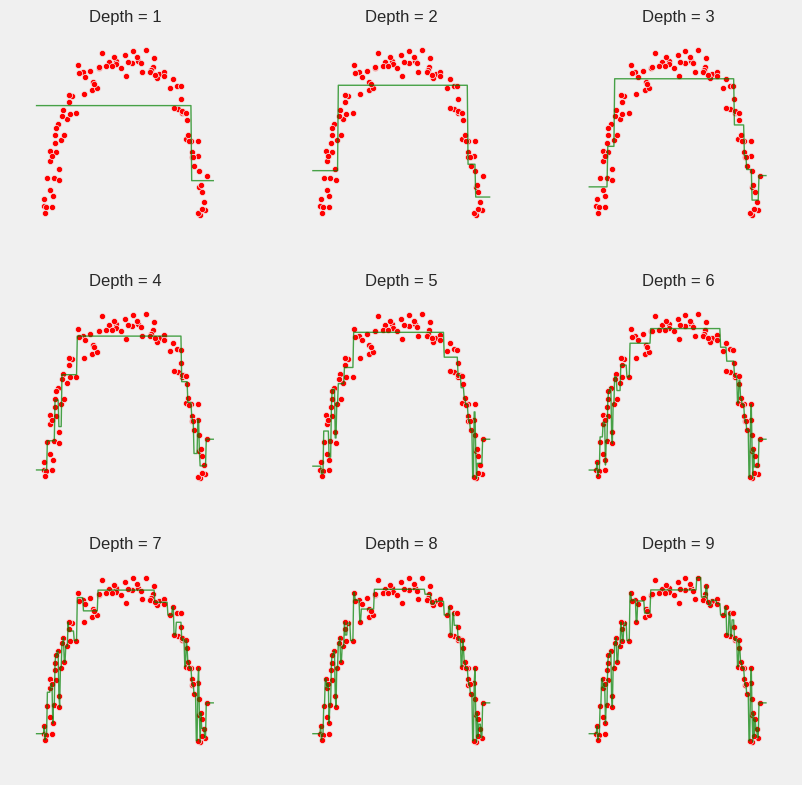

In [13]:
# create a 3x3 grid of plots
f, axarr = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        depth = (i * 3) + (j + 1) # complicated magic
        clf = tree.DecisionTreeRegressor(max_depth=depth).fit(X, y)

        preds = clf.predict(X_test)
        
        axarr[i,j].scatter(X, y, c = 'r')
        axarr[i,j].plot(X_test, preds, c="g", label="max_depth={}".format(depth), linewidth=1., alpha=0.7)
        axarr[i,j].set_title("Depth = {}".format(depth), fontsize=12)

        axarr[i,j].axes.get_xaxis().set_ticks([])
        axarr[i,j].axes.get_yaxis().set_ticks([])

plt.show() 

## Decision tree learning

#### Criterion: Information gain (Kullbach - Liebler divergence)
**Formal definition:** The expected information gain (IG) is the change in information entropy H from a prior state to a state that takes some information. 

$$ IG(D_p, f) = I(D_p) - \sum_{j=1}^{m} \frac{N_j}{N} I(D_j) $$

Where $D_p$ is the **parent** dataset at the point where we decide the split, $f = (f_1, \dots, f_j, \dots, f_m)$ the feature for which we are calculating the information gain, $D_j$ the dataset left after splitting the parent dataset on each feature value $f_j$ and $N_j$ is the number of samples in the part of dataset $D_j$.

Here, $I$ represents the generalized **measure of impurity** of the data. Entropy is one instance of an impurity measure, alongside which Gini impurity and classification error are also used. Information gain criterion chooses the split that **maximizes** the purity of the data, which can be seen as the **homogeneity** of the data post-split.

### Impurity measures for classification
#### Entropy
Shannon's entropy (H) is defined in information theory as the expected value of information contained in each message. In simpler terms, it captures the **uncertainty** of a random variable.

$$ H(p) \stackrel{binary}{=} -p \cdot log_2(p) - (1 - p) \cdot log_2(1-p) \stackrel{general}{=} -\sum_{i=1}^{C} p_i \cdot {log_2 p_i} $$


Where $p_i$ is the probability of outcome $i$ from the set of all possible outcomes $C$.

In [14]:
# Define some class probabilities to visualize various impurity measures
step_size = .01
X = np.arange(0, 1 + step_size, step_size)

X = np.vstack((X, 1. - X))
assert all((X[0] + X[1]) == 1), "Probabilities don't sum to one"
# We get an array of (p, 1-p)

In [15]:
# Entropy - 
def unsafe_entropy(probabilities):
    return -np.sum(probabilities * np.log2(probabilities))

def entropy(probabilities): 
    nonzero_indices = np.where(probabilities > 0.)
    probabilities = probabilities[nonzero_indices]
    return -np.sum(probabilities * np.log2(probabilities))

print entropy(np.array([.5, .5])), unsafe_entropy(np.array([.5, .5]))
print entropy(np.array([1.])), unsafe_entropy(np.array([1.]))
print entropy(np.array([0., 1.])), unsafe_entropy(np.array([0., 1.]))

1.0 1.0
-0.0 -0.0
-0.0 nan


In [16]:
hx = np.apply_along_axis(entropy, 0, X) # Calculate entropy for each (p, 1-p) pair

#### Gini impurity

**Formally:** Gini impurity (G) is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.

$$ G(p) \stackrel{general}{=} \sum_{i=1}^{C} p_i \cdot (1 - p_i) = \sum_{i=1}^{C} p_i - \sum_{i=1}^{C} p_i^2 = 1 - \sum_{i=1}^{C} p_i^2$$

In [17]:
# Gini impurity
def gini(probabilities):
    return 1. - np.sum(probabilities * probabilities)

gx = np.apply_along_axis(gini, 0, X)

#### Classification error
The classification error (CE) is defined as the uncertainty of all but the most probable variable. 

$$ CE = 1 - \max_i p_i$$

In [18]:
def classification_error(probabilites):
    return 1. - np.max(probabilites)

cex = np.apply_along_axis(classification_error, 0, X)

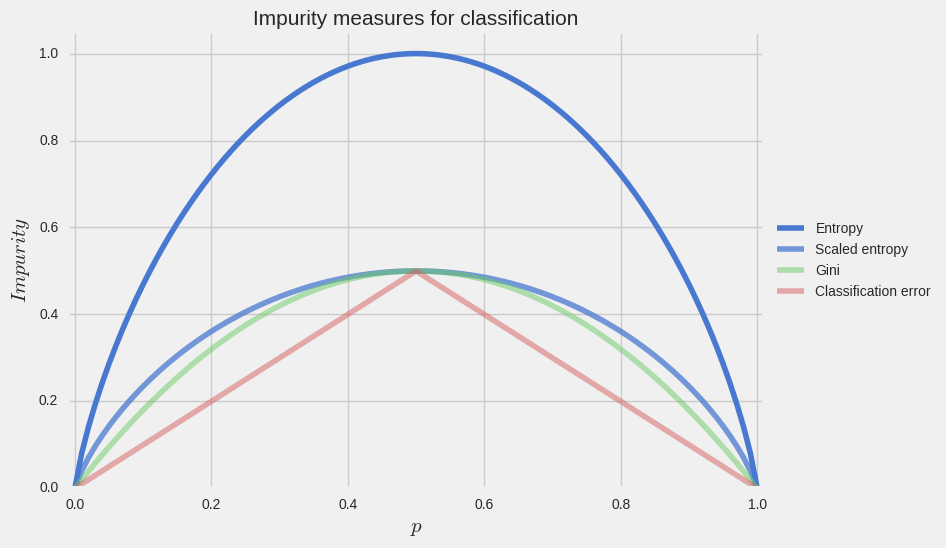

In [19]:
# pretty colors
colors = sns.color_palette("muted")

plt.plot(X[0], hx, label='Entropy', c = colors[0])
plt.plot(X[0], hx/2, label='Scaled entropy', c = colors[0], alpha=0.75)
plt.plot(X[0], gx, label='Gini', c = colors[1], alpha = 0.5)
plt.plot(X[0], cex, label='Classification error', c = colors[2], alpha = 0.5)

plt.xlim([-0.01, 1.01])
plt.ylim([0, 1.05])
plt.xlabel('$p$', fontsize=15)
plt.ylabel('$Impurity$', fontsize=15)
plt.title("Impurity measures for classification", fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()

## Impurity measure~~(s)~~ for regression

### Mean squared error

We still use the same criterion, however the impurity measure is the mean square error (MSE) of a split at a certain value of a feature. 

To fully understand this, you have to know that the prediction for the output value at a certain node is the mean target value of all the training samples that have reached that node. Therefore, we can define the MSE of a node as:

$$ MSE(D) = \frac{1}{N_d} \sum_{i}^{N_d} (\hat{Y} - Y_i)^2$$

Where $D$ is the subset of the dataset at the current node, $N_d$ the amount of samples in the subset of the dataset, and $\hat{Y}$ the prediction - or the mean target value of all the samples in $D$


### Tennis dataset
Meet John. John is very lazy. John is actually so lazy that he does not want to make his own decisions for himself, but would rather automate the process. In order to do so, he tracked weather data at times that his friends invited him to play tennis and the outcomes of those invites. He wants to not only train a classifier that makes decisions for him, but also understand how it works.


#### Working with categorical and ordinal features

In [20]:
df = pd.read_csv("dataset/tennis-categorical.csv")
print df

     Outlook Temperature Humidity Windy PlayTennis
0      sunny         hot     high    No         No
1      sunny         hot     high   Yes         No
2   overcast         hot     high    No        Yes
3       rain        mild     high    No        Yes
4       rain        cool   normal    No        Yes
5       rain        cool   normal   Yes         No
6   overcast        cool   normal   Yes        Yes
7      sunny        mild     high    No         No
8      sunny        cool   normal    No        Yes
9       rain        mild   normal    No        Yes
10     sunny        mild   normal   Yes        Yes
11  overcast        mild     high   Yes        Yes
12  overcast         hot   normal    No        Yes
13      rain        mild     high   Yes         No


In [21]:
# split columns into X and y names
features = df.columns.values[:-1]
target = df.columns.values[-1]
target_values = list(np.unique(df[target]))
print features, target

['Outlook' 'Temperature' 'Humidity' 'Windy'] PlayTennis


#### Identify important features


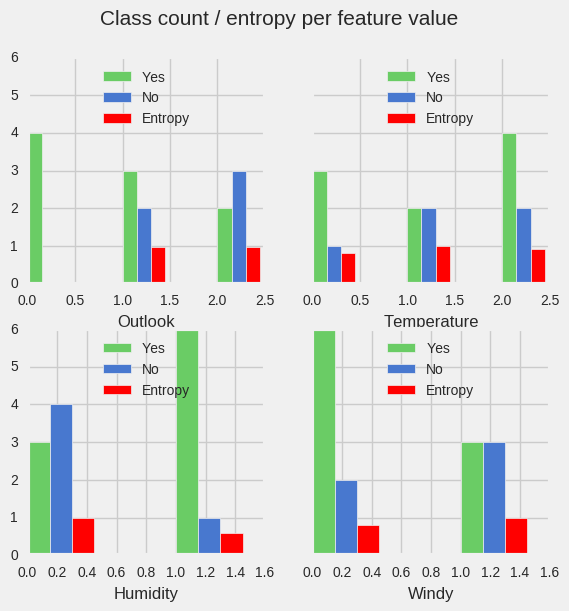

In [27]:
colors = sns.color_palette("muted")

f, axarr = plt.subplots(2, 2, figsize=(6, 6), sharey=True)
f.suptitle('Class count / entropy per feature value', fontsize=15)

measures = {entropy: [], gini:[], classification_error:[]}

for idx, feature in enumerate(features): 

    feature_values = np.unique(df[feature])
    
    target_stats = {target:[] for target in target_values}
    
    for feature_value in feature_values: 
        subset = df.ix[df[feature] == feature_value]
        target_distribution = Counter(subset[target])
        
        for t in target_values: 
            if t in target_distribution: 
                target_stats[t].append(target_distribution[t])
            else:
                target_stats[t].append(0)
    
    #########################
    #       plotting
    #########################
    
    N = len(feature_values)
    indices = np.arange(N)
    width = 0.15
    
    i = idx / 2
    j = idx % 2
    
    # This probably could have been done a LOT easier 
    vals = [target_stats[t] for t in target_stats]
    freqs = zip(vals[0], vals[1])
    probs = [np.array(list(freq), dtype=float) for freq in freqs]
    probs = [prob / np.sum(prob) for prob in probs] 
    entropies = [entropy(prob) for prob in probs]
    
    for idx, t in enumerate(target_stats):
        wplus = idx * width
        #print wplus, target_stats[t]
        axarr[i,j].bar(indices + wplus, target_stats[t], width, label=t, color=colors[1 -idx])

        axarr[i,j].set_xlabel(feature, fontsize=12)
        
    wplus = 2 * width
    axarr[i,j].bar(indices + wplus, entropies, width, label='Entropy', color='r')
    axarr[i,j].legend(loc = 'upper center')  

plt.show()


In [28]:
# sklearn does not work with categorical features!
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(df[features], df[target])

ValueError: could not convert string to float: Yes

In [29]:
# let's try again
dummy_features = pd.get_dummies(df[features])
print dummy_features 

    Outlook_overcast  Outlook_rain  Outlook_sunny  Temperature_cool  \
0                0.0           0.0            1.0               0.0   
1                0.0           0.0            1.0               0.0   
2                1.0           0.0            0.0               0.0   
3                0.0           1.0            0.0               0.0   
4                0.0           1.0            0.0               1.0   
5                0.0           1.0            0.0               1.0   
6                1.0           0.0            0.0               1.0   
7                0.0           0.0            1.0               0.0   
8                0.0           0.0            1.0               1.0   
9                0.0           1.0            0.0               0.0   
10               0.0           0.0            1.0               0.0   
11               1.0           0.0            0.0               0.0   
12               1.0           0.0            0.0               0.0   
13    

In [30]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(dummy_features, df[target])
feature_names = dummy_features.columns.values

model_to_plot(clf, 'out/tennistree.pdf', feature_names, target_values)

from IPython.display import IFrame
IFrame("out/tennistree.pdf", width=800, height=900)